In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 25, 10

df = pd.read_csv("compas-scores-two-years.csv")

## Yiyuan

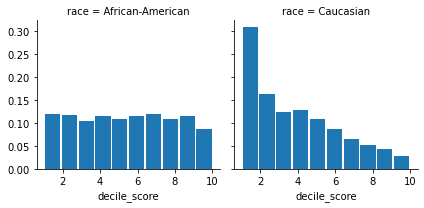

In [3]:
RACE_IN_FOCUS = ['African-American', 'Caucasian']
df_race_focused = df[df['race'].isin(RACE_IN_FOCUS)]
g = sns.FacetGrid(df_race_focused, col='race')
g.map(plt.hist, 'decile_score', rwidth=0.9,density = True)

In [4]:
pd.crosstab(df_race_focused['decile_score'], df['race'], normalize = 'columns')

race,African-American,Caucasian
decile_score,,
1,0.107684,0.277506
2,0.106331,0.147107
3,0.093615,0.111247
4,0.104167,0.116137
5,0.098755,0.098207
6,0.103896,0.079055
7,0.108225,0.058272
8,0.097132,0.046455
9,0.102814,0.039935


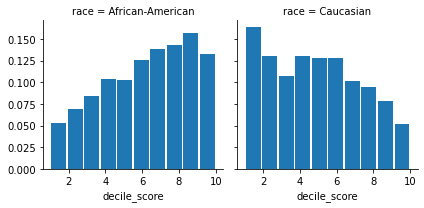

In [5]:
recid_df = df.loc[df['two_year_recid']==1]
recid_df_race_focused = recid_df[recid_df['race'].isin(RACE_IN_FOCUS)]
g = sns.FacetGrid(recid_df_race_focused, col='race')
g.map(plt.hist, 'decile_score', rwidth=0.9, density = True)

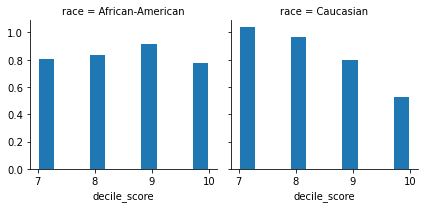

In [6]:
high_decile_recide = recid_df.loc[recid_df['decile_score'] > 6]
focused_high_decile = high_decile_recide[high_decile_recide['race'].isin(RACE_IN_FOCUS)]
g = sns.FacetGrid(focused_high_decile, col='race')
g.map(plt.hist, 'decile_score', rwidth=0.9,density = True)

In [7]:
df = df.fillna(0)
df = df.replace({'race' : { 'African-American' : 0, 'Asian' : 1, 'Caucasian' : 3 ,'Hispanic':4,'Native American':5,'Other':6}})
df = df.replace({'sex' : { 'Male' : 1, 'Female' : 0}})

corr_df = pd.DataFrame(columns=['r','p'])
for col in df:
    if pd.api.types.is_numeric_dtype(df[col]):
        r,p = stats.pearsonr(df.two_year_recid,df[col])
        corr_df.loc[col] = [round(r,3),round(p,3)]

cor_value = abs(corr_df.r).sort_values(ascending=False)
cor_value.head(20)

C:\Users\18589\anaconda3\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


two_year_recid             1.000
is_recid                   0.941
event                      0.786
end                        0.771
is_violent_recid           0.356
decile_score               0.351
decile_score.1             0.351
v_decile_score             0.296
priors_count               0.275
priors_count.1             0.275
age                        0.190
r_days_from_arrest         0.161
race                       0.127
juv_misd_count             0.109
juv_other_count            0.108
juv_fel_count              0.093
sex                        0.092
start                      0.080
c_days_from_compas         0.068
days_b_screening_arrest    0.025
Name: r, dtype: float64

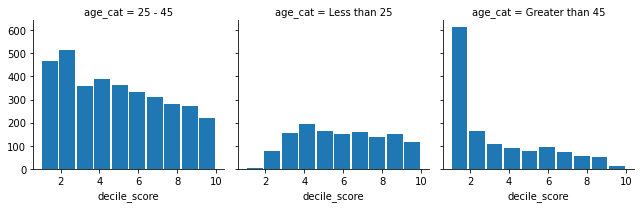

In [8]:
g = sns.FacetGrid(df_race_focused, col='age_cat')
g.map(plt.hist, 'decile_score', rwidth=0.9)

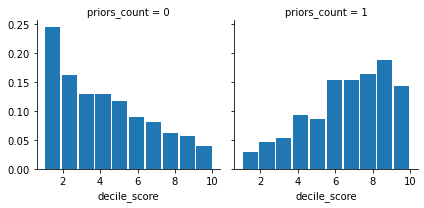

In [9]:
import numpy as np
df_race_focused["priors_count"] = np.where(df_race_focused["priors_count"] <= 5, 0, 1)
g = sns.FacetGrid(df_race_focused, col='priors_count')
g.map(plt.hist, 'decile_score', rwidth=0.9,density = True)